# Usefull code for lab


In [ ]:
# !pip install --upgrade networkx
# !pip install matplotlib
# !pip install tqdm

In [76]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, groupby
import numpy as np
from numpy import inf

### Graph generation


In [150]:
# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 0)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

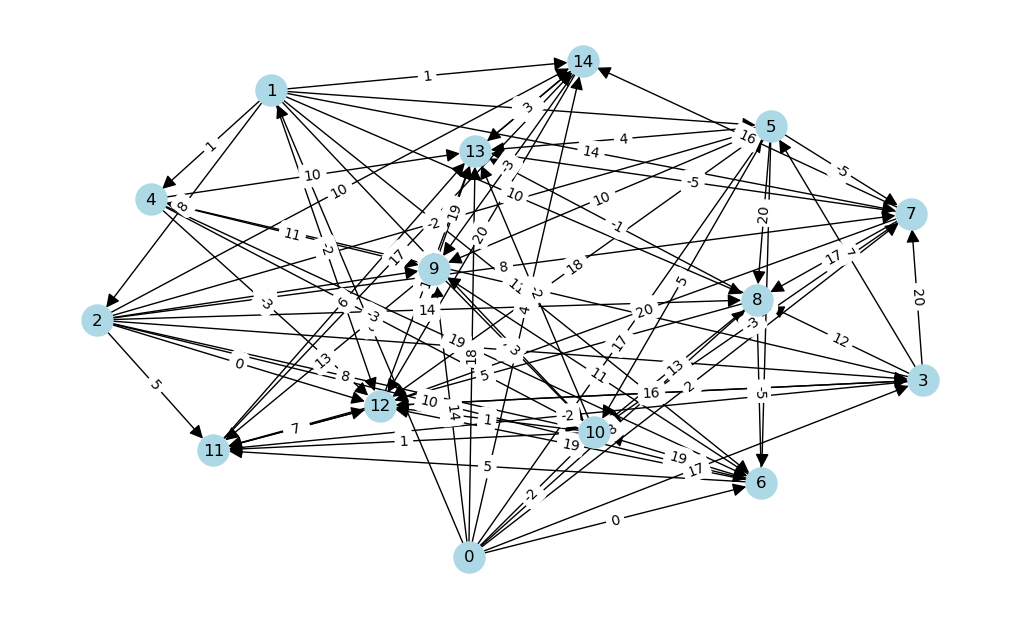

In [108]:
G = gnp_random_connected_graph(15, 0.7, True, True)

# Algorithms

## Bellman-Ford algorithm


### Built-in algorithm


In [54]:
from networkx.algorithms import bellman_ford_predecessor_and_distance

In [56]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 3)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Distance to 3: 0
Distance to 4: 20
Distance to 5: 14
Distance to 7: 14
Distance to 1: 29


### Our algorithm

In [55]:
def bellman_ford(G, start_point:int = 0):
    path = {start_point: 0}
    path.update({i: float('inf') for i in list(G.nodes()) if i != start_point})
    edges = list(G.edges(data=True))
    i = 0
    while i <= len(list(G.nodes())):
        path_copy = path.copy()
        for node, weight in path.items():
            if weight == float('inf'):
                # print(node)
                continue
            for edge in edges:
                if node == edge[0]:
                    path[edge[1]] = min(path[edge[1]], weight + edge[2]['weight'])
        if i == len(list(G.nodes())) and path_copy != path:
            return 'Negative cycle detected'
        elif path_copy == path:
            return path
        i += 1

    return path

try: 
    for node, path_weight in bellman_ford(G, 3).items():
        print(f"Distance to {node}:", path_weight)
except AttributeError:
    print(bellman_ford(G, 3))


Distance to 3: 0
Distance to 0: inf
Distance to 1: 29
Distance to 2: inf
Distance to 4: 20
Distance to 5: 14
Distance to 6: inf
Distance to 7: 14
Distance to 8: inf
Distance to 9: inf


#### Floyd Warshall

In [68]:
from networkx.algorithms import floyd_warshall_predecessor_and_distance

NodeDataView({0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}})

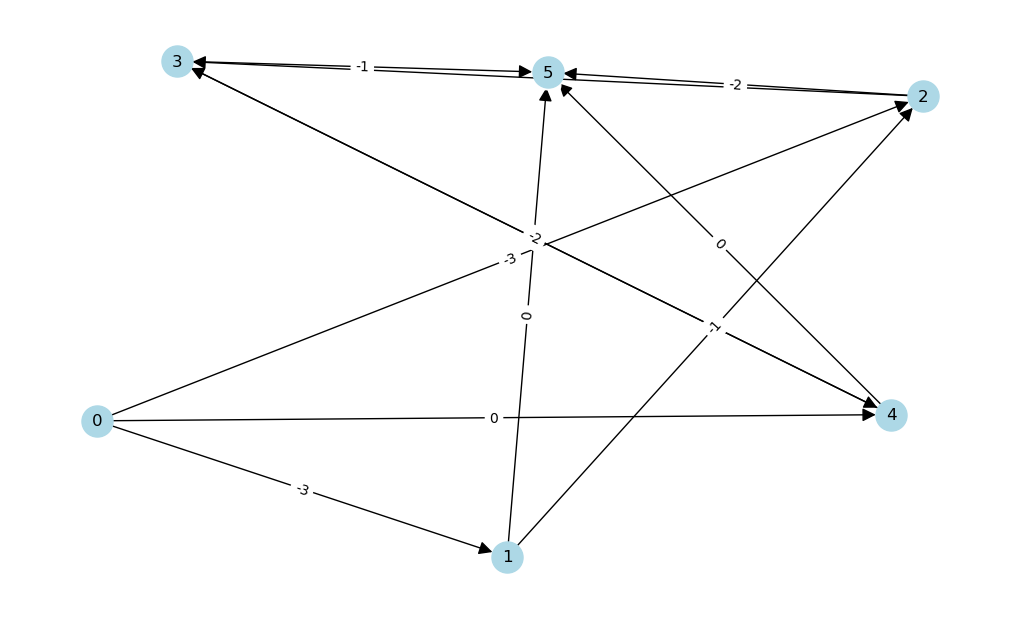

In [175]:
G = gnp_random_connected_graph(6, 0.5, True, True)

In [176]:
list(G.edges(data=True))

[(0, 1, {'weight': -3}),
 (0, 2, {'weight': -3}),
 (0, 4, {'weight': 0}),
 (1, 2, {'weight': -1}),
 (1, 5, {'weight': 0}),
 (2, 3, {'weight': -5}),
 (2, 5, {'weight': -2}),
 (3, 4, {'weight': 0}),
 (3, 5, {'weight': -1}),
 (4, 3, {'weight': -2}),
 (4, 5, {'weight': 0})]

In [177]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G) 
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

Distances with 0 source: {0: 0, 1: -3, 2: -4, 4: -11, 3: -11, 5: -14}
Distances with 1 source: {1: 0, 2: -1, 5: -11, 0: inf, 3: -8, 4: -8}
Distances with 2 source: {2: 0, 3: -7, 5: -10, 0: inf, 1: inf, 4: -7}
Distances with 3 source: {3: -2, 4: -2, 5: -5, 0: inf, 1: inf, 2: inf}
Distances with 4 source: {4: -4, 3: -4, 5: -7, 0: inf, 1: inf, 2: inf}
Distances with 5 source: {5: 0, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf}


In [96]:
def check_negative_cycles(matrix):
    for i in range(len(matrix)):
        if matrix[i][i] < 0:
            return True
    return False

In [178]:
def floyd_warshall(G):
    nodes = list(G.nodes())
    matrix = np.zeros((len(nodes), len(nodes)), dtype=np.float32)
    edges = {(edge[0],edge[1]): edge[2]['weight'] for edge in G.edges(data=True)}
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if i == j and (i, j) not in edges:
                matrix[i][j] = 0
            elif (i, j) in edges:
                matrix[i][j] = edges[(i, j)]
            else:
                matrix[i][j] = inf
    i = 0
    while i + 1 <= len(nodes):
        for k in range(len(nodes)):
            if k == 1:
                continue
            for h in range(len(nodes)):
                if h == i:
                    continue
                matrix[k][h] = min(matrix[k][h], matrix[k][i] + matrix[i][h])
        if check_negative_cycles(matrix):
            return 'Negative cycle detected'
        i += 1
    return matrix
floyd_warshall(G)

'Negative cycle detected'

# Comperasion with built-in algorithm

In [22]:
import time
from tqdm import tqdm

In [34]:
def comparison(nodes: int):
  NUM_OF_ITERATIONS = 1000
  time_taken = 0
  time_taken_built = 0
  for i in tqdm(range(NUM_OF_ITERATIONS)):
      
      # note that we should not measure time of graph creation
      G = gnp_random_connected_graph(nodes, 0.5, True)
      
      start = time.time()
      bellman_ford(G)
      end = time.time()
      
      time_taken += end - start

      start_built = time.time()
      try: 
        bellman_ford_predecessor_and_distance(G, 0)
      except:
        None
      end_built = time.time()

      time_taken_built +=  end_built - start_built
  return(time_taken/NUM_OF_ITERATIONS, time_taken_built/NUM_OF_ITERATIONS)

### Plot of comparison with built-in algorithm


100%|██████████| 1000/1000 [01:12<00:00, 13.87it/s]


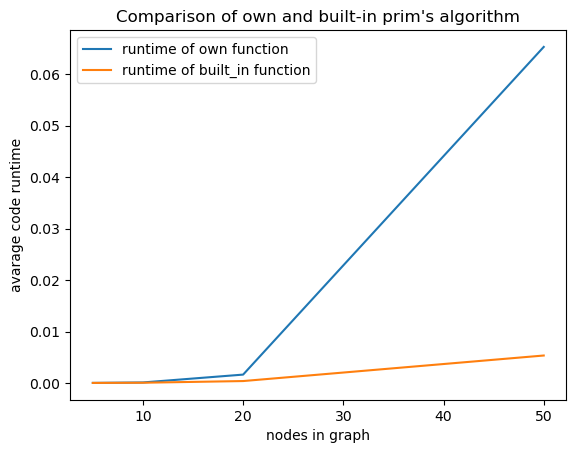

In [57]:
nodes_amount = [5, 10, 20, 50]
own_maked_time = []
built_in_time = []
for nodes in nodes_amount:
  own_func, built_in_func = comparison(nodes)
  own_maked_time.append(own_func)
  built_in_time.append(built_in_func)

plt.plot(nodes_amount, own_maked_time, label ='runtime of own function')
plt.plot(nodes_amount, built_in_time, label ='runtime of built_in function')
plt.xlabel('nodes in graph')
plt.ylabel('avarage code runtime')
plt.title("Comparison of own and built-in prim's algorithm")
plt.legend()